In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import gsw
import copy
import os
import glob
import pickle

In [3]:
datapd = pd.read_csv("all_coord.csv")

In [4]:
import zarr
import gcsfs
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [4]:
path_data = '/mnt/c/Users/shunzi/Documents/Penn/Research/CMIP6/DATA'

In [5]:
def cal_mld(sigma0, lev):
    b0 = sigma0[lev].where(~sigma0.isnull()).max(dim = lev)
    if sigma0[lev].min() >= 10:
        sigma0_10 = sigma0.sel({lev: 10}, method = 'nearest')
    else:
        sigma0_10 = sigma0.interp({lev: 10})
    mld0 = sigma0[lev].where(sigma0 - sigma0_10 <= 0.03).max(dim = lev)
    mld1 = sigma0[lev].where(sigma0[lev] > mld0).min(dim = lev)
    sigma0_cal = sigma0.where((sigma0[lev] >= mld0) & (sigma0[lev] <= mld1))
    cal_min = sigma0_cal.min(dim = lev)
    cal_max = sigma0_cal.max(dim = lev)
    mld2 = (mld1 - mld0)/(cal_max - cal_min) * (sigma0_10 + 0.03 - cal_min) + mld0
    mld = xr.where(mld0 < b0, mld2, b0)
    return mld

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster.adapt(minimum=1, maximum=50) 
client = Client(cluster)
client

2024-02-18 23:42:49,616 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-2924ulhg', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38585,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.61 GiB
Comm: tcp://127.0.0.1:33713,Total threads: 2
Dashboard: http://127.0.0.1:38203/status,Memory: 1.90 GiB
Nanny: tcp://127.0.0.1:37455,


2024-02-18 23:42:53,262 - tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7fee2007e5c0>, <Task finished name='Task-1214' coro=<BaseTCPListener._handle_stream() done, defined at /home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/distributed/comm/tcp.py:605> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/tornado/ioloop.py", line 738, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/tornado/tcpserver.py", line 387, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
                                           ^^^^^^^^^^
  File "/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/distributed/comm/tcp.py", line 611, in _handle_stream
    logger.debug("Incoming c

In [ ]:
for f in os.listdir(path_data):
    if f != 'GISS-E2-2-H':
        continue
    new_path = path_data + '/' + f
    fpath = 'data_mld/' + f + '.pickle'
    # print(new_path)

    sf = new_path + "/so*.nc"
    tf = new_path + "/thetao*.nc"
    # print(new_sof)
    dss = xr.open_mfdataset(sf)
    dst = xr.open_mfdataset(tf)

    das = dss.so
    dat = dst.thetao
    
    if 'type' in das.coords:
        das = das.reset_coords('type', drop = True)
        dat = dat.reset_coords('type', drop = True)
    
    da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))

    levname = datapd.loc[datapd['source_id'] == f]['zname'].values[0]
    if 'units' in das[levname].attrs:
        if das[levname].units == 'centimeters':
            da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m

    if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
        if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
            print("{} doesn't have regular grid.".format(f))
            continue
        else:
            da_south = da_sigma0.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, -50)})
            # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
            pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
            plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
            pltx, plty = np.meshgrid(pltx0, plty0)
    else:
        da_south = da_sigma0.where(da_sigma0[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < -50, drop=True)
        pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
        plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
    
    if len(np.shape(pltx)) > 2:
        pltx = pltx.isel(time = 0)
        plty = plty.isel(time = 0)

    da_sep = list(da_south.groupby('time.month'))[8][-1]
    da_mld = cal_mld(da_sep, levname)
    
    mldmax = da_mld.max("time")
    mld2000 = da_mld.where(da_mld >= 2000).count('time')
    mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)
    
    newd = {"mldmax":mldmax.load(), 
            "mld2kfq":mld2000_frq.load(), 
            "pltx":pltx, 
            "plty":plty}
    
    with open(fpath, 'wb') as wf:
        pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)
        
    print("{}: finished".format(f))


    break

In [45]:
for f in os.listdir(path_data):
    if f != 'IPSL-CM5A2-INCA':
        continue
    new_path = path_data + '/' + f
    all_files = os.listdir(new_path)
    s_files = [file for file in all_files if file.startswith("so_Omon")]
    t_files = [file for file in all_files if file.startswith("thetao_Omon")]

    s_files.sort()
    t_files.sort()
    
    # Iterate through the pairs of files
    fn = 0
    for s_file, t_file in zip(s_files, t_files):
        s_file_path = os.path.join(new_path, s_file)
        t_file_path = os.path.join(new_path, t_file)
        
        s_longname = s_file.split('_')[1:]
        t_longname = t_file.split('_')[1:]
        
        if s_longname == t_longname:

            chunksize = {"time":24,
                         datapd.loc[datapd['source_id'] == f].iloc[0]['xname']:180,
                         datapd.loc[datapd['source_id'] == f].iloc[0]['yname']:180}

            dss = xr.open_dataset(s_file_path, chunks=chunksize)
            dst = xr.open_dataset(t_file_path, chunks=chunksize)

            if 'type' in das.coords:
                das = das.reset_coords('type', drop = True)
                dat = dat.reset_coords('type', drop = True)

            levname = datapd.loc[datapd['source_id'] == f]['zname'].values[0]

            fns = np.linspace(0, len(dss.so.time), 11)
            for fn in range(0, len(fns)-1):
                savepath = 'data_mld0/' + f + '_' + str(fn) + '.pickle'
                if os.path.exists(savepath):
                    continue

                das = dss.so.isel(time = slice(int(fns[fn]), int(fns[fn+1])))
                dat = dst.thetao.isel(time = slice(int(fns[fn]), int(fns[fn+1])))

                da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))
                
                if 'units' in das[levname].attrs:
                    if das[levname].units == 'centimeters':
                        da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m
                        
                
                if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
                    if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
                        print("{} doesn't have regular grid.".format(f))
                        continue
                    else:
                        da_south = da_sigma0.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, -50)})
                        # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
                        pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
                        plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
                        pltx, plty = np.meshgrid(pltx0, plty0)
                else:
                    da_south = da_sigma0.where(da_sigma0[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < -50, drop=True)
                    pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
                    plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
                
                if len(np.shape(pltx)) > 2:
                    pltx = pltx.isel(time = 0)
                    plty = plty.isel(time = 0)
                    
                da_sep = list(da_south.groupby('time.month'))[8][-1]
                da_mld = cal_mld(da_sep, levname)
                da_mld_new = da_mld.load()
                
                with open(savepath, 'wb') as wf:
                    pickle.dump(da_mld_new, wf, pickle.HIGHEST_PROTOCOL)

        # else:
        #     print(s_longname)
        #     print(t_longname)
        #     break
            # if fn == 0:
            #     da_mld_all = da_mld_new.load()
            # else:
            #     da_mld_all = xr.concat([da_mld_all, da_mld_new], dim="time")
            # if fn > 2:
            #     break
            # fn = fn + 1
            
        

    # mldmax = da_mld.max("time")
    # mld2000 = da_mld.where(da_mld >= 2000).count('time')
    # mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)
    
    # newd = {"mldmax":mldmax.load(), 
    #         "mld2kfq":mld2000_frq.load(), 
    #         "pltx":pltx, 
    #         "plty":plty}
    
    # with open(fpath, 'wb') as wf:
    #     pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)
        
    # print("{}: finished".format(f))
            
            # break

/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/sh/pkgs/miniconda3/envs/work/lib/python3.11/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/sh/pkgs/miniconda3/envs/wor

In [11]:
for f in os.listdir(path_data):
    if f != 'CanESM5-1':
        continue
    new_path = path_data + '/' + f
    all_files = os.listdir(new_path)
    s_files = [file for file in all_files if file.startswith("so_Omon")]
    t_files = [file for file in all_files if file.startswith("thetao_Omon")]

    s_files.sort()
    t_files.sort()
    
    # Iterate through the pairs of files
    fn = 0
    for s_file, t_file in zip(s_files, t_files):
        s_file_path = os.path.join(new_path, s_file)
        t_file_path = os.path.join(new_path, t_file)
        
        s_longname = s_file.split('_')[1:]
        t_longname = t_file.split('_')[1:]
        
        if s_longname != t_longname:
            print('time span does not match ')
            break
        else:
            dss = xr.open_dataset(s_file_path)
            dst = xr.open_dataset(t_file_path)

            if 'type' in dss.coords:
                das = dss.reset_coords('type', drop = True)
                dat = dst.reset_coords('type', drop = True)

            levname = datapd.loc[datapd['source_id'] == f]['zname'].values[0]

            nfns = np.linspace(0, len(dss.so.time), int(len(dss.so.time)/12+1))

            for nfn in range(0, len(nfns)-1):
                sfn = fn + nfn
                savepath = 'data_mld0/' + f + '_' + str(sfn) + '.pickle'
                if os.path.exists(savepath):
                    continue
                print('file {}, number {}, time {} - {}'.format(s_file, sfn, nfns[nfn], nfns[nfn+1]))

                das = dss.so.isel(time = slice(int(nfns[nfn]), int(nfns[nfn+1])))
                dat = dst.thetao.isel(time = slice(int(nfns[nfn]), int(nfns[nfn+1])))

                da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))
                
                if 'units' in das[levname].attrs:
                    if das[levname].units == 'centimeters':
                        da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m
                        
                
                if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
                    if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
                        print("{} doesn't have regular grid.".format(f))
                        continue
                    else:
                        da_south = da_sigma0.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, -50)})
                        # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
                        pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
                        plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
                        pltx, plty = np.meshgrid(pltx0, plty0)
                else:
                    da_south = da_sigma0.where(da_sigma0[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < -50, drop=True)
                    pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
                    plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
                
                if len(np.shape(pltx)) > 2:
                    pltx = pltx.isel(time = 0)
                    plty = plty.isel(time = 0)
                    
                da_sep = list(da_south.groupby('time.month'))[8][-1]
                da_mld = cal_mld(da_sep, levname)
                da_mld_new = da_mld.load()
                
                with open(savepath, 'wb') as wf:
                    pickle.dump(da_mld_new, wf, pickle.HIGHEST_PROTOCOL)
            fn = sfn + 1

        # else:
        #     print(s_longname)
        #     print(t_longname)
        #     break
            # if fn == 0:
            #     da_mld_all = da_mld_new.load()
            # else:
            #     da_mld_all = xr.concat([da_mld_all, da_mld_new], dim="time")
            # if fn > 2:
            #     break
            # fn = fn + 1
            
        

    # mldmax = da_mld.max("time")
    # mld2000 = da_mld.where(da_mld >= 2000).count('time')
    # mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)
    
    # newd = {"mldmax":mldmax.load(), 
    #         "mld2kfq":mld2000_frq.load(), 
    #         "pltx":pltx, 
    #         "plty":plty}
    
    # with open(fpath, 'wb') as wf:
    #     pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)
        
    # print("{}: finished".format(f))
            
            # break

file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 14, time 36.0 - 48.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 15, time 48.0 - 60.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 16, time 60.0 - 72.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 17, time 72.0 - 84.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 18, time 84.0 - 96.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 19, time 96.0 - 108.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_601101-602012.nc, number 20, time 108.0 - 120.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_602101-603012.nc, number 21, time 0.0 - 12.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_602101-603012.nc, number 22, time 12.0 - 24.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_602101-603012.nc, number 23, time 24.0 - 36.0
file so_Omon_CanESM5-1_piControl_r1i1p1f1_gn_602101-603012.nc, number 24, time 36.0 - 48

In [13]:
for f in os.listdir(path_data):
    if f != 'E3SM-2-0':
        continue
    new_path = path_data + '/' + f
    all_files = os.listdir(new_path)
    s_files = [file for file in all_files if file.startswith("so_Omon")]
    t_files = [file for file in all_files if file.startswith("thetao_Omon")]

    s_files.sort()
    t_files.sort()
    
    # Iterate through the pairs of files
    fn = 0
    for s_file, t_file in zip(s_files, t_files):
        s_file_path = os.path.join(new_path, s_file)
        t_file_path = os.path.join(new_path, t_file)
        
        s_longname = s_file.split('_')[1:]
        t_longname = t_file.split('_')[1:]
        
        if s_longname != t_longname:
            print('time span does not match ')
            break
        else:
            chunksize = {"time":12}

            dss = xr.open_dataset(s_file_path, chunks=chunksize)
            dst = xr.open_dataset(t_file_path, chunks=chunksize)

            levname = datapd.loc[datapd['source_id'] == f]['zname'].values[0]

            nfns = np.linspace(0, len(dss.so.time), 2) #int(len(dss.so.time)/12+1))

            for nfn in range(0, len(nfns)-1):
                sfn = fn + nfn
                savepath = 'data_mld0/' + f + '_' + str(sfn) + '.pickle'
                # if os.path.exists(savepath):
                #     continue
                print('file {}, number {}, time {} - {}'.format(s_file, sfn, nfns[nfn], nfns[nfn+1]))

                das = dss.so.isel(time = slice(int(nfns[nfn]), int(nfns[nfn+1])))
                dat = dst.thetao.isel(time = slice(int(nfns[nfn]), int(nfns[nfn+1])))

                da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))
                
                if 'units' in das[levname].attrs:
                    if das[levname].units == 'centimeters':
                        da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m
                        
                
                if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
                    if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
                        print("{} doesn't have regular grid.".format(f))
                        continue
                    else:
                        da_south = da_sigma0.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, -50)})
                        # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
                        pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
                        plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
                        pltx, plty = np.meshgrid(pltx0, plty0)
                else:
                    da_south = da_sigma0.where(da_sigma0[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < -50, drop=True)
                    pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
                    plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
                
                if len(np.shape(pltx)) > 2:
                    pltx = pltx.isel(time = 0)
                    plty = plty.isel(time = 0)
                    
                da_sep = list(da_south.groupby('time.month'))[8][-1]
                da_mld = cal_mld(da_sep, levname)
                da_mld_new = da_mld.load()
                break

                # with open(savepath, 'wb') as wf:
                #     pickle.dump(da_mld_new, wf, pickle.HIGHEST_PROTOCOL)
            fn = sfn + 1
            break
        


file so_Omon_E3SM-2-0_piControl_r1i1p1f1_gr_000101-000512.nc, number 0, time 0.0 - 60.0


2024-02-18 23:55:24,460 - distributed.nanny - WARNING - Worker process still alive after 3.1999981689453127 seconds, killing
2024-02-18 23:55:24,486 - distributed.nanny - WARNING - Worker process still alive after 3.1999983215332035 seconds, killing
2024-02-18 23:55:27,882 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.30 GiB -- Worker memory limit: 1.90 GiB
2024-02-18 23:55:28,162 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.35 GiB -- Worker memory limit: 1.90 GiB
2024-02-18 23:55:28,259 - distributed.worker

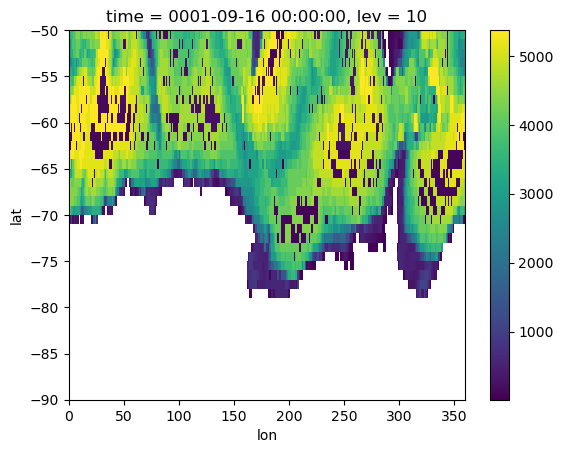

In [15]:
da_mld_new.isel(time=0).plot()

In [24]:
da_sigma0.isel(time=0, lev = 0)

<xarray.DataArray 'so' (lat: 180, lon: 360)>
dask.array<getitem, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     object 0001-01-16 12:00:00
    lev      float64 5.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    standard_name:  sea_water_salinity
    long_name:      Sea Water Salinity
    comment:        Sea water salinity is the salt content of sea water, ofte...
    units:          0.001
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2022-11-23T23:29:07Z altered by CMOR: replaced missing va...

In [28]:
model1 = 'E3SM-2-0'

In [27]:
sfn

99

In [29]:
for newfn in range(0, sfn+1):
    picklefilename = 'data_mld0/' + model1 + '_' + str(newfn) + '.pickle'
    with open(picklefilename, 'rb') as pf:
        mld_data0 = pickle.load(pf)
    if newfn == 0:
        da_mld_all = mld_data0
    else:
        da_mld_all = xr.concat([da_mld_all, mld_data0], dim="time")


In [30]:
mldmax = da_mld_all.max("time")
mld2000 = da_mld.where(da_mld >= 2000).count('time')
mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)

newd = {"mldmax":mldmax, 
        "mld2kfq":mld2000_frq,
        "pltx":pltx, 
        "plty":plty}


datasavepath = 'data_mld/' + model1 + '.pickle'
with open(datasavepath, 'wb') as wf:
        pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)

In [13]:
model1 = 'CanESM5-1'

In [16]:
for f in os.listdir(path_data):
    if f != model1:
        continue
    new_path = path_data + '/' + f
    all_files = os.listdir(new_path)
    s_files = [file for file in all_files if file.startswith("so_Omon")]
    t_files = [file for file in all_files if file.startswith("thetao_Omon")]

    s_files.sort()
    t_files.sort()
    
    # Iterate through the pairs of files
    fn = 0
    for s_file, t_file in zip(s_files, t_files):
        savepath = 'data_mld0/' + f + '_' + str(fn) + '.pickle'
        if os.path.exists(savepath):
            fn += 1
            continue

        s_file_path = os.path.join(new_path, s_file)
        t_file_path = os.path.join(new_path, t_file)
        
        s_longname = s_file.split('_')[1:]
        t_longname = t_file.split('_')[1:]
        
        if s_longname == t_longname:

            chunksize = {"time":12}

            dss = xr.open_dataset(s_file_path, chunks=chunksize)
            dst = xr.open_dataset(t_file_path, chunks=chunksize)

            das = dss.so
            dat = dst.thetao

            if 'type' in das.coords:
                das = das.reset_coords('type', drop = True)
                dat = dat.reset_coords('type', drop = True)

            
            da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))

            levname = datapd.loc[datapd['source_id'] == f]['zname'].values[0]
            if 'units' in das[levname].attrs:
                if das[levname].units == 'centimeters':
                    da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m

            if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
                if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
                    print("{} doesn't have regular grid.".format(f))
                    continue
                else:
                    da_south = da_sigma0.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, -50)})
                    # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
                    pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
                    plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
                    pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                da_south = da_sigma0.where(da_sigma0[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < -50, drop=True)
                pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
                plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
                

            if len(np.shape(pltx)) > 2:
                pltx = pltx.isel(time = 0)
                plty = plty.isel(time = 0)

            da_sep = list(da_south.groupby('time.month'))[8][-1]
            da_mld = cal_mld(da_sep, levname)
            da_mld_new = da_mld.load()

            with open(savepath, 'wb') as wf:
                pickle.dump(da_mld_new, wf, pickle.HIGHEST_PROTOCOL)
            fn += 1
        else:
            print(s_longname)
            print(t_longname)
            break
            # if fn == 0:
            #     da_mld_all = da_mld_new.load()
            # else:
            #     da_mld_all = xr.concat([da_mld_all, da_mld_new], dim="time")
            # if fn > 2:
            #     break
            # fn = fn + 1
            
        

    # mldmax = da_mld.max("time")
    # mld2000 = da_mld.where(da_mld >= 2000).count('time')
    # mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)
    
    # newd = {"mldmax":mldmax.load(), 
    #         "mld2kfq":mld2000_frq.load(), 
    #         "pltx":pltx, 
    #         "plty":plty}
    
    # with open(fpath, 'wb') as wf:
    #     pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)
        
    # print("{}: finished".format(f))
            
            # break

2024-01-13 14:44:57,350 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.37 GiB -- Worker memory limit: 1.90 GiB
2024-01-13 14:44:57,410 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.39 GiB -- Worker memory limit: 1.90 GiB
2024-01-13 14:44:57,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KilledWorker: Attempted to run task ('sigma0-getitem-116e5f52a4dd0fcee8cabf5b0dbe8ffa', 2, 0, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:46117. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2024-01-13 14:47:06,991 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.64 GiB -- Worker memory limit: 1.90 GiB
2024-01-13 14:47:07,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.64 GiB -- Worker memory limit: 1.90 GiB
2024-01-13 14:47:07,197 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [18]:
for newfn in range(0, fn):
    picklefilename = 'data_mld0/' + model1 + '_' + str(newfn) + '.pickle'
    with open(picklefilename, 'rb') as pf:
        mld_data0 = pickle.load(pf)
    if newfn == 0:
        da_mld_all = mld_data0
    else:
        da_mld_all = xr.concat([da_mld_all, mld_data0], dim="time")


In [20]:
mldmax = da_mld_all.max("time")
mld2000 = da_mld.where(da_mld >= 2000).count('time')
mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)

newd = {"mldmax":mldmax, 
        "mld2kfq":mld2000_frq,
        "pltx":pltx, 
        "plty":plty}


datasavepath = 'data_mld/' + model1 + '.pickle'
with open(datasavepath, 'wb') as wf:
        pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)

In [13]:
dss.so

<xarray.DataArray 'so' (time: 132, lev: 45, j: 291, i: 360)>
dask.array<open_dataset-44adb7f7568d960efda2794ef16bf889so, shape=(132, 45, 291, 360), dtype=float32, chunksize=(24, 45, 291, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 6000-01-16 12:00:00 ... 6010-12-16 12:00:00
  * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_salinity
    long_name:      Sea Water Salinity
    comment:        Sea water salinity is the salt content of sea water, ofte...
    units:          0.001
    original_name:  vosaline
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello

In [ ]:
for f in os.listdir(path_data):
    if f != 'GISS-E2-2-H':
        continue
    new_path = path_data + '/' + f
    fpath = 'data_mld/' + f + '.pickle'
    # print(new_path)

    sf = new_path + "/so*.nc"
    tf = new_path + "/thetao*.nc"
    # print(new_sof)
    dss = xr.open_mfdataset(sf)
    dst = xr.open_mfdataset(tf)

    das = dss.so
    dat = dst.thetao
    
    if 'type' in das.coords:
        das = das.reset_coords('type', drop = True)
        dat = dat.reset_coords('type', drop = True)
    
    da_sigma0 = gsw.sigma0(das.where(das > 0), dat.where(dat != 0))

    levname = datapd.loc[datapd['source_id'] == f]['zname'].values[0]
    if 'units' in das[levname].attrs:
        if das[levname].units == 'centimeters':
            da_sigma0[levname] = da_sigma0[levname]/100 # unit: cm --> m

    if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
        if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
            print("{} doesn't have regular grid.".format(f))
            continue
        else:
            da_south = da_sigma0.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, -50)})
            # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
            pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
            plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
            pltx, plty = np.meshgrid(pltx0, plty0)
    else:
        da_south = da_sigma0.where(da_sigma0[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < -50, drop=True)
        pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
        plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
    
    if len(np.shape(pltx)) > 2:
        pltx = pltx.isel(time = 0)
        plty = plty.isel(time = 0)

    da_sep = list(da_south.groupby('time.month'))[8][-1]
    da_mld = cal_mld(da_sep, levname)
    
    mldmax = da_mld.max("time")
    mld2000 = da_mld.where(da_mld >= 2000).count('time')
    mld2000_frq = mld2000.where(mld2000>0)/len(da_mld.time)
    
    newd = {"mldmax":mldmax.load(), 
            "mld2kfq":mld2000_frq.load(), 
            "pltx":pltx, 
            "plty":plty}
    
    with open(fpath, 'wb') as wf:
        pickle.dump(newd, wf, pickle.HIGHEST_PROTOCOL)
        
    print("{}: finished".format(f))


    break

In [54]:
datapd.loc[datapd['source_id'] == f].iloc[0]['xname']

'lon'

In [21]:
from intake import open_esm_datastore
col = open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [5]:
cat = col.search(variable_id = ['thetao', 'so'], experiment_id = 'piControl')
nlist = cat.df.source_id.unique()
collist = list(cat)

In [6]:
cat.df.to_csv("dataset_st_raw.csv")

In [11]:
datapd

,source_id,member_id,variable_id,grid_label,zstore
0,ACCESS-CM2,r1i1p1f1,so,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...
1,ACCESS-CM2,r1i1p1f1,thetao,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...
2,ACCESS-ESM1-5,r1i1p1f1,so,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piCo...
3,ACCESS-ESM1-5,r1i1p1f1,thetao,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piCo...
4,AWI-CM-1-1-MR,r1i1p1f1,thetao,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/piCont...
...,...,...,...,...,...
115,SAM0-UNICON,r1i1p1f1,thetao,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/piContro...
116,TaiESM1,r1i1p1f1,so,gn,gs://cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/piContro...
117,TaiESM1,r1i1p1f1,thetao,gn,gs://cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/piContro...
118,UKESM1-0-LL,r1i1p1f2,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/piContr...


In [22]:
cat = col.search(variable_id = ['thetao', 'so'], experiment_id = 'piControl', source_id = 'EC-Earth3-LR')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,EC-Earth-Consortium,EC-Earth3-LR,piControl,r1i1p1f1,Oclim,so,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20190103
1,CMIP,EC-Earth-Consortium,EC-Earth3-LR,piControl,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200919
2,CMIP,EC-Earth-Consortium,EC-Earth3-LR,piControl,r1i1p1f1,Omon,so,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200919


In [13]:
cat.df.zstore[1]

'gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-LR/piControl/r1i1p1f1/Omon/so/gn/v20200919/'

In [5]:
xr.open_zarr(gcs.get_mapper("gs://cmip6/CMIP6/CMIP/NUIST/NESM3/piControl/r1i1p1f1/SImon/siconc/gn/v20190704/"), consolidated=True)

<xarray.Dataset>
Dimensions:    (nj: 384, ni: 320, vertices: 4, time: 6000, bnds: 2)
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nj, ni, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nj, ni, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1000-01-16 12:00:00 ... 1499-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
    type       |S7 ...
Dimensions without coordinates: vertices, bnds
Data variables:
    siconc     (time, nj, ni) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  182621.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/40b9f2c5-6404-4ecf-8e4a-5f429f866b25...
    variable_id:            siconc
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/40b9f2c5-6404-4ecf-8e4a-5f429f866b25...
    version_id:             v20190704

In [12]:
xr.open_zarr(gcs.get_mapper(cat.df.zstore[1]), consolidated=True)

<xarray.Dataset>
Dimensions:             (i: 362, j: 292, lev: 75, bnds: 2, time: 12, vertices: 4)
Coordinates:
  * i                   (i) int32 1 2 3 4 5 6 7 ... 356 357 358 359 360 361 362
  * j                   (j) int32 1 2 3 4 5 6 7 ... 286 287 288 289 290 291 292
    latitude            (j, i) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * time                (time) datetime64[ns] 1991-01-16T12:00:00 ... 1991-12...
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    so                  (time, lev, j, i) float32 dask.array<chunksize=(4, 75, 292, 362), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
Attributes: (12/51)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             none provided
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    tracking_id:               hdl:21.14100/2550bc38-65f1-49a6-b171-ced15e93dbf1
    variable_id:               so
    variant_info:              forcing: Nat.Ant.
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/2550bc38-65f1-49a6-b171-ced15e93dbf1
    version_id:                v20200919

In [19]:
import intake
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/leap-persistent-ro/data-library/catalogs/cmip6-test/leap-pangeo-cmip6-test.json"
)
cat = col.search(variable_id = ['thetao', 'so'], experiment_id = 'piControl')

In [20]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


In [ ]:
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/leap-persistent-ro/data-library/catalogs/cmip6-test/leap-pangeo-cmip6-test.json"
)

In [12]:
cat['CMIP.EC-Earth-Consortium.EC-Earth3-LR.piControl.Omon.gn'].to_dask()

ESMDataSourceError: Failed to load dataset with key='CMIP.EC-Earth-Consortium.EC-Earth3-LR.piControl.Omon.gn'
                 You can use `cat['CMIP.EC-Earth-Consortium.EC-Earth3-LR.piControl.Omon.gn'].df` to inspect the assets/files for this key.
                 

In [17]:
for i in range(0, int(len(datapd)/2)):
    if datapd.at[2*i, 'source_id'] == datapd.at[2*i+1, 'source_id']:
        if datapd.at[2*i, 'member_id'] == datapd.at[2*i+1, 'member_id']:
            if datapd.at[2*i, 'grid_label'] == datapd.at[2*i+1, 'grid_label']:
                ds1 = xr.open_zarr(gcs.get_mapper(datapd.at[2*i,'zstore']), consolidated=True)
                # ds2 = xr.open_zarr(gcs.get_mapper(datapd.at[2*i+1,'zstore']), consolidated=True)
                print(datapd.at[2*i, 'source_id'], ' ', datapd.at[2*i, 'grid_label'])
                print(ds1[datapd.at[2*i, 'variable_id']], '\n')
                
            else:
                print(i)
        else:
            print(i)
    else:
        print(i)


ACCESS-CM2   gn
<xarray.DataArray 'so' (time: 6000, lev: 50, j: 300, i: 360)>
dask.array<open_dataset-bb5ef641f173de21cc6f7ef908fc7fb1so, shape=(6000, 50, 300, 360), dtype=float32, chunksize=(6, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time       (time) object 0950-01-16 12:00:00 ... 1449-12-16 12:00:00
Attributes:
    cell_measures:   area: areacello volume: volcello
    cell_methods:    area: mean where sea time: mean
    comment:         Sea water salinity is the salt content of sea water, oft...
    long_name:       Sea Water Salinity
    original_units:  psu
    standard_name: 